In [48]:
## Standard libraries
import os
from copy import deepcopy

## Imports for plotting
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.set()

## tqdm for loading bars
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

## Torchvision
import torchvision
from torchvision.datasets import STL10
from torchvision import transforms

# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# Import tensorboard
%load_ext tensorboard

# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "saved_models/tutorial17"
# In this notebook, we use data loaders with heavier computational processing. It is recommended to use as many
# workers as possible in a data loader, which corresponds to the number of CPU cores
NUM_WORKERS = os.cpu_count()

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print("Device:", device)
print("Number of workers:", NUM_WORKERS)


/var/folders/3l/70h6qcrd72q0j5x4sscw7qn40000gn/T/ipykernel_95340/4136117935.py:10: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export
Seed set to 42


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Device: mps
Number of workers: 10


<Figure size 640x480 with 0 Axes>

In [51]:
import urllib.request
from urllib.error import HTTPError
# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial17/"
# Files to download
pretrained_files = ["SimCLR.ckpt", "ResNet.ckpt",
                    "tensorboards/SimCLR/events.out.tfevents.SimCLR",
                    "tensorboards/classification/ResNet/events.out.tfevents.ResNet"]
pretrained_files += [f"LogisticRegression_{size}.ckpt" for size in [10, 20, 50, 100, 200, 500]]
# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if "/" in file_name:
        os.makedirs(file_path.rsplit("/",1)[0], exist_ok=True)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)

In [52]:
CHECKPOINT_PATH

'saved_models/tutorial17'

In [61]:
from contrastive_learning.dataloader import *

In [62]:
labeled_dataloader, unlabeled_dataloader = get_datasets(labeled_split=0.2)

Class to Index Mapping: {'Black Sea Sprat': 0, 'Gilt-Head Bream': 1, 'Hourse Mackerel': 2, 'Red Mullet': 3, 'Red Sea Bream': 4, 'Sea Bass': 5, 'Shrimp': 6, 'Striped Red Mullet': 7, 'Trout': 8}

Processing Class: Black Sea Sprat
Number of Images Found: 1000
Number of Masks Found: 1000

Processing Class: Gilt-Head Bream
Number of Images Found: 1000
Number of Masks Found: 1000

Processing Class: Hourse Mackerel
Number of Images Found: 1000
Number of Masks Found: 1000

Processing Class: Red Mullet
Number of Images Found: 1000
Number of Masks Found: 1000

Processing Class: Red Sea Bream
Number of Images Found: 1000
Number of Masks Found: 1000

Processing Class: Sea Bass
Number of Images Found: 1000
Number of Masks Found: 1000

Processing Class: Shrimp
Number of Images Found: 1000
Number of Masks Found: 1000

Processing Class: Striped Red Mullet
Number of Images Found: 1000
Number of Masks Found: 1000

Processing Class: Trout
Number of Images Found: 1000
Number of Masks Found: 1000

Total Im

In [64]:
from contrastive_learning.plotting import *

# Example Iteration: Labeled DataLoader
for batch in labeled_dataloader:
    print(type(batch))
    batch = batch
    break

<class 'list'>


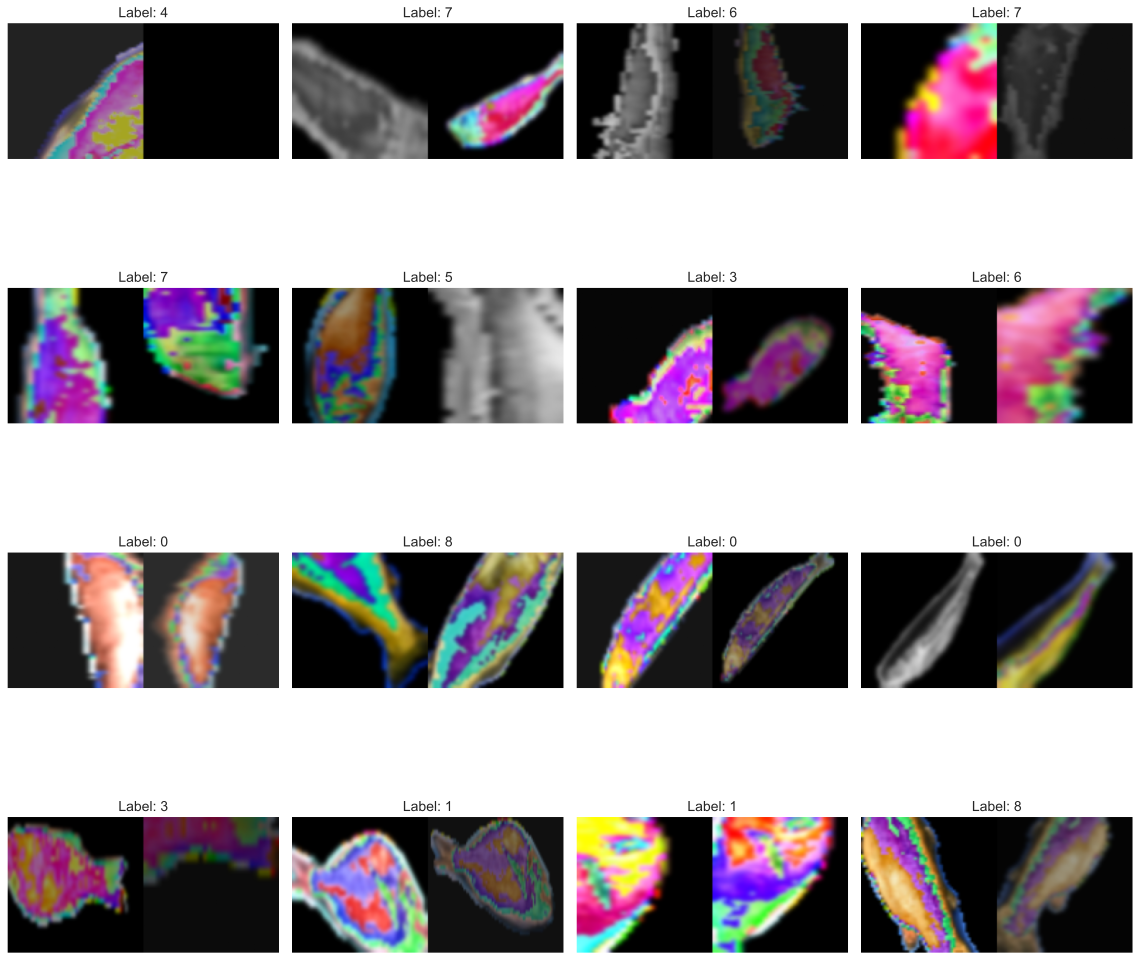

In [65]:
from contrastive_learning.plotting import *

plot_contrastive_image_pairs(batch)

In [66]:
# Example Iteration: Labeled DataLoader
for batch2 in unlabeled_dataloader:
    batch2 = batch2
    break

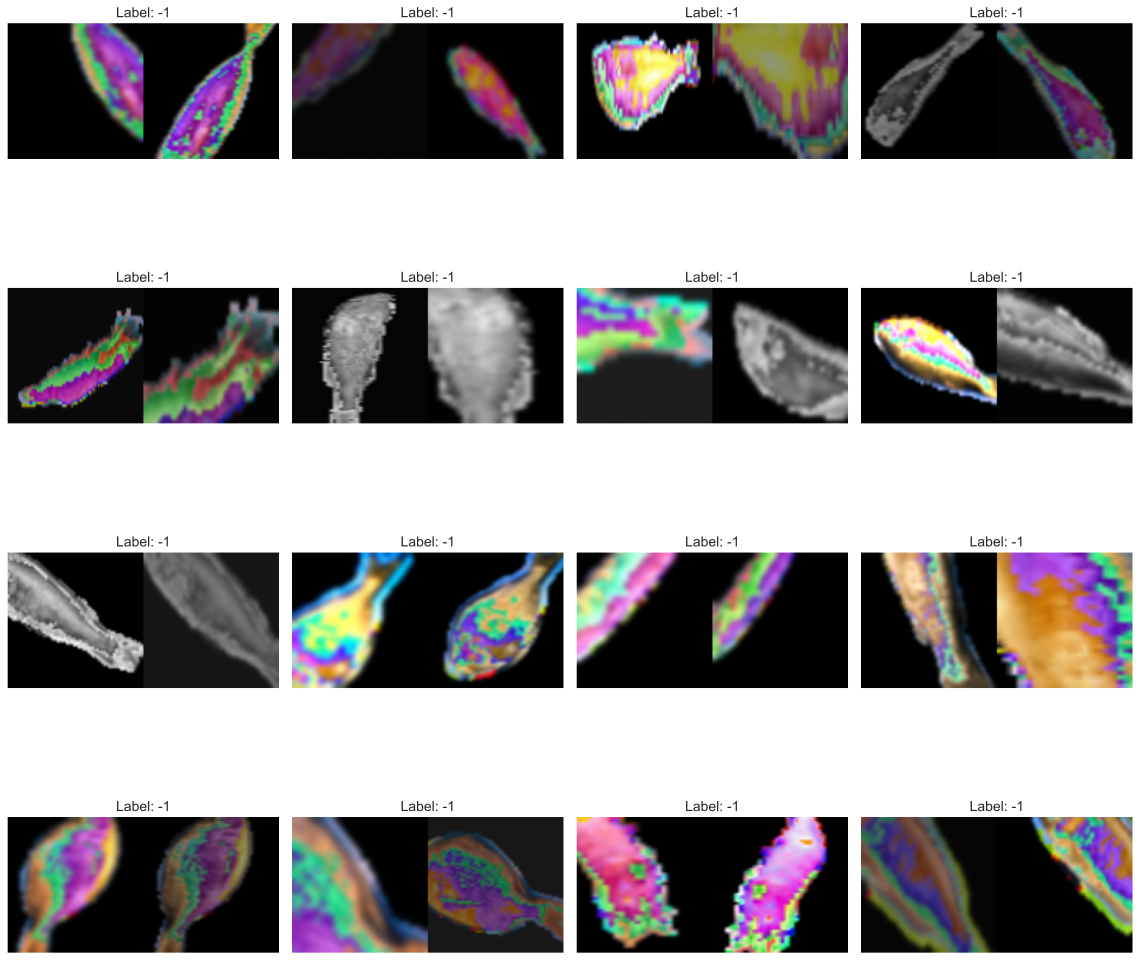

In [67]:
plot_contrastive_image_pairs(batch2)

In [17]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def plot_tensor(tensor):
  # If tensor is on GPU, move it to CPU
  try:
    tensor = tensor.cpu()
  except:
    pass

  if len(tensor.size()) == 4:
    tensor = tensor.squeeze(0)

  # Convert to NumPy
  np_image = tensor.numpy()

  np_image = np.transpose(np_image, (1, 2, 0))

  # Example normalization parameters (commonly used for pretrained models)
  mean = np.array(np_image)
  std = np.array(np_image)

  # Unnormalize the image
  np_image = std * np_image + mean

  # Clip the values to [0, 1] range for display
  np_image = np.clip(np_image, 0, 1)


  plt.imshow(np_image)
  plt.axis('off')  # Hide axis
  plt.show()

In [18]:
batch[1]

tensor([2, 6, 1, 2, 8, 8, 7, 8, 6, 7, 4, 4, 7, 5, 8, 5])

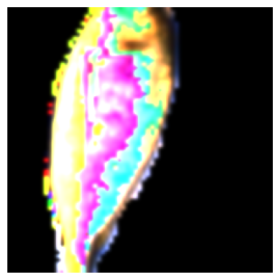

In [26]:
plot_tensor(batch[0][2][0])

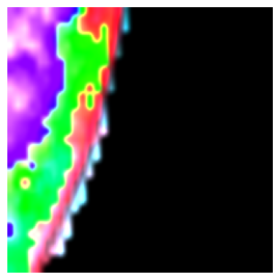

In [27]:
plot_tensor(batch[0][2][1])

In [21]:
# Example Iteration: Labeled DataLoader
for batch2 in unlabeled_dataloader:
    batch2 = batch2
    break

In [30]:
batch2[1]

tensor([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1])

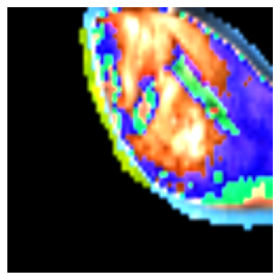

In [28]:
plot_tensor(batch2[0][2][0])

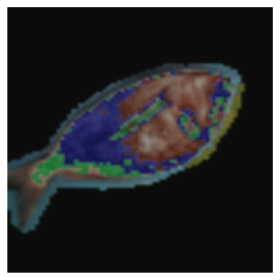

In [29]:
plot_tensor(batch2[0][2][1])

In [31]:
from contrastive_learning.plotting import *

# Example Iteration: Labeled DataLoader
for batch in labeled_dataloader:
        print(batch.keys())
        images = batch['image']  # Shape: [batch_size, 3, 256, 256]
        masks = batch['mask']    # Shape: [batch_size, 1, 256, 256]
        contrastive_image = batch['contrastive_image']
        labels = batch['label']  # Shape: [batch_size]
        is_labeled = batch['is_labeled']  # Shape: [batch_size]
        break

plot_combined_grid(images=images,  contrastive_images=contrastive_image, labels=labels)

AttributeError: 'list' object has no attribute 'keys'

dict_keys(['image', 'mask', 'label', 'is_labeled', 'contrastive_image'])


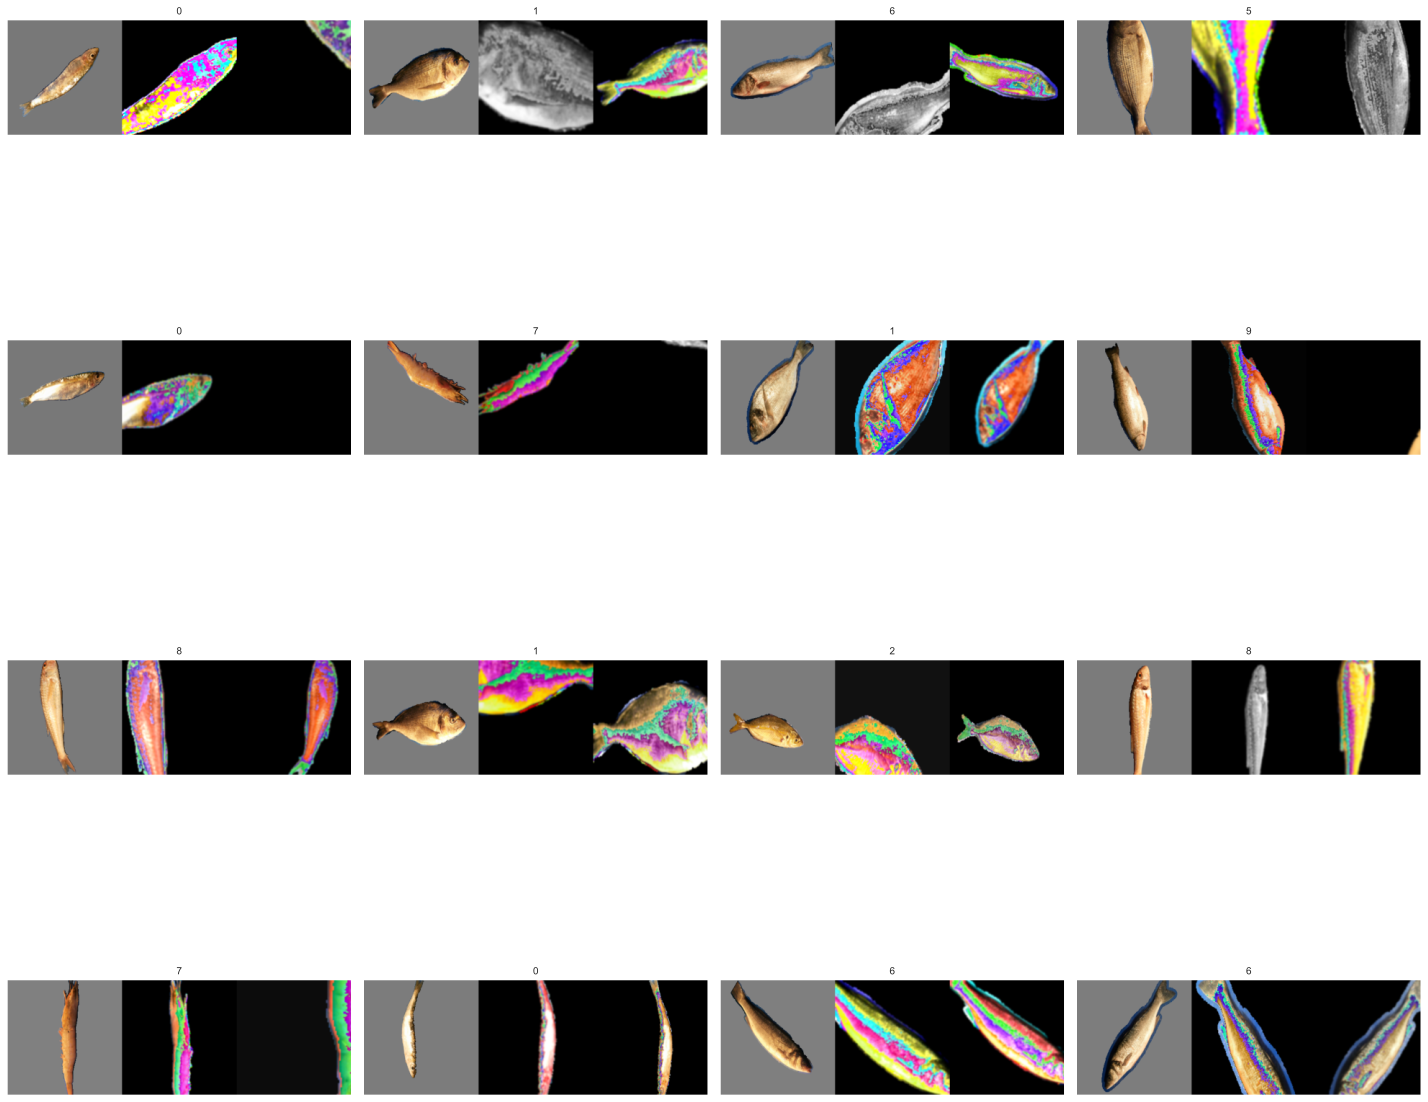

In [13]:
from contrastive_learning.plotting import *

# Example Iteration: Labeled DataLoader
for batch in unlabeled_dataloader:
        print(batch.keys())
        images = batch['image']  # Shape: [batch_size, 3, 256, 256]
        masks = batch['mask']    # Shape: [batch_size, 1, 256, 256]
        contrastive_image = batch['contrastive_image']
        labels = batch['label']  # Shape: [batch_size]
        is_labeled = batch['is_labeled']  # Shape: [batch_size]
        break

plot_combined_grid(images=images,  contrastive_images=contrastive_image, labels=labels)

In [7]:
contrastive_image[0].unique()

tensor([0.0000, 0.0039, 0.0078, 0.0118, 0.0157, 0.0196, 0.0235, 0.0275, 0.0314,
        0.0353, 0.0392, 0.0431, 0.0471, 0.0510, 0.0549, 0.0588, 0.0627, 0.0667,
        0.0706, 0.0745, 0.0784, 0.0824, 0.0863, 0.0902, 0.0941, 0.0980, 0.1020,
        0.1059, 0.1098, 0.1137, 0.1176, 0.1216, 0.1255, 0.1294, 0.1333, 0.1373,
        0.1412, 0.1451, 0.1490, 0.1529, 0.1569, 0.1608, 0.1647, 0.1686, 0.1725,
        0.1765, 0.1804, 0.1843, 0.1882, 0.1922, 0.1961, 0.2000, 0.2039, 0.2078,
        0.2118, 0.2157, 0.2196, 0.2235, 0.2275, 0.2314, 0.2353, 0.2392, 0.2431,
        0.2471, 0.2510, 0.2549, 0.2588, 0.2627, 0.2667, 0.2706, 0.2745, 0.2784,
        0.2824, 0.2863, 0.2902, 0.2941, 0.2980, 0.3020, 0.3059, 0.3098, 0.3137,
        0.3176, 0.3216, 0.3255, 0.3294, 0.3333, 0.3373, 0.3412, 0.3451, 0.3490,
        0.3529, 0.3569, 0.3608, 0.3647, 0.3686, 0.3725, 0.3765, 0.3804, 0.3843,
        0.3882, 0.3922, 0.3961, 0.4000, 0.4039, 0.4078, 0.4118, 0.4157, 0.4196,
        0.4235, 0.4275, 0.4314, 0.4353, 

In [7]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from pytorch_lightning import LightningModule
from torchmetrics import Accuracy

class SimCLR(LightningModule):
    def __init__(self, hidden_dim, lr, temperature, weight_decay, max_epochs=500):
        super().__init__()
        self.save_hyperparameters()
        assert self.hparams.temperature > 0.0, 'The temperature must be a positive float!'
        
        # Base model f(.)
        self.convnet = torchvision.models.resnet18(num_classes=4 * hidden_dim)  # Output of last linear layer
        
        # The MLP for g(.) consists of Linear->ReLU->Linear
        self.convnet.fc = nn.Sequential(
            self.convnet.fc,  # Linear(ResNet output, 4*hidden_dim)
            nn.ReLU(inplace=True),
            nn.Linear(4 * hidden_dim, hidden_dim)
        )
        
        # Metrics
        self.train_acc_top1 = Accuracy(top_k=1, task='multiclass', num_classes=7)
        self.train_acc_top5 = Accuracy(top_k=5, task='multiclass', num_classes=7)
        self.val_acc_top1 = Accuracy(top_k=1, task='multiclass', num_classes=7)
        self.val_acc_top5 = Accuracy(top_k=5, task='multiclass', num_classes=7)
    
    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(),
                                lr=self.hparams.lr,
                                weight_decay=self.hparams.weight_decay)
        lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer,
                                                            T_max=self.hparams.max_epochs,
                                                            eta_min=self.hparams.lr / 50)
        return [optimizer], [lr_scheduler]
    
    def info_nce_loss(self, batch, mode='train'):
        """
        Computes the InfoNCE loss for SimCLR.
        
        Args:
            batch (dict): A batch from the DataLoader containing 'contrastive_image'.
            mode (str): 'train' or 'val' for logging purposes.
        
        Returns:
            torch.Tensor: The computed loss.
        """
        # Extract contrastive images
        contrastive_images = batch.get('contrastive_image', None)
        if contrastive_images is None:
            raise ValueError("Batch does not contain 'contrastive_image' key.")
        
        batch_size, n_views, C, H, W = contrastive_images.shape  # [batch_size, n_views, C, H, W]
        
        # Reshape to [batch_size * n_views, C, H, W]
        contrastive_images = contrastive_images.view(-1, C, H, W)
        
        # Pass through the convnet
        feats = self.convnet(contrastive_images)  # [batch_size * n_views, hidden_dim]
        
        # Normalize features
        feats = F.normalize(feats, dim=1)
        
        # Compute similarity matrix
        similarity_matrix = torch.matmul(feats, feats.T)  # [batch_size * n_views, batch_size * n_views]
        
        # Mask out self-similarity
        mask = torch.eye(similarity_matrix.size(0), dtype=torch.bool, device=similarity_matrix.device)
        similarity_matrix.masked_fill_(mask, -9e15)
        
        # Positive pairs: assume n_views=2, positives are batch_size apart
        # For example, if n_views=2, then for sample i, view1 is at i*2 and view2 is at i*2 +1
        # Thus, positives for view1 are view2 and vice versa
        if n_views != 2:
            raise ValueError("n_views must be 2 for this implementation.")
        
        # Create labels for contrastive loss
        labels = torch.cat([torch.arange(batch_size) + i * batch_size for i in range(n_views)], dim=0).to(feats.device)

        
        # Scale similarities by temperature
        logits = similarity_matrix / self.hparams.temperature
        
        # Compute cross-entropy loss
        loss = F.cross_entropy(logits, labels)
        
        # Logging loss
        self.log(f"{mode}_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        
        # Compute accuracy metrics
        # For top-1 accuracy, the correct class is the positive pair
        preds = logits.argmax(dim=1)
        correct_top1 = (preds == labels).float().mean()
        self.log(f"{mode}_acc_top1", correct_top1, on_step=True, on_epoch=True, prog_bar=True)
        
        # For top-5 accuracy
        top5 = torch.topk(logits, k=5, dim=1).indices
        correct_top5 = (top5 == labels.unsqueeze(1)).any(dim=1).float().mean()
        self.log(f"{mode}_acc_top5", correct_top5, on_step=True, on_epoch=True, prog_bar=True)
        
        return loss
    
    def training_step(self, batch, batch_idx):
        return self.info_nce_loss(batch, mode='train')
    
    def validation_step(self, batch, batch_idx):
        self.info_nce_loss(batch, mode='val')


In [8]:
import os
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor

def train_simclr(batch_size, max_epochs=500, unlabeled_dataloader=None, labeled_dataloader=None, **kwargs):
    """
    Trains the SimCLR model using PyTorch Lightning.
    
    Args:
        batch_size (int): The batch size for training.
        max_epochs (int): The number of epochs to train.
        unlabeled_dataloader (DataLoader): DataLoader for unlabeled data.
        labeled_dataloader (DataLoader): DataLoader for labeled data (used as validation).
        **kwargs: Additional keyword arguments for SimCLR.
    
    Returns:
        SimCLR: The trained SimCLR model.
    """
    # Define checkpoint path
    CHECKPOINT_PATH = './checkpoints'  # Replace with your desired path
    device = torch.device('mps' if torch.backends.mps.is_available()  else 'cpu')
    
    # Initialize Trainer
    trainer = pl.Trainer(
        default_root_dir=os.path.join(CHECKPOINT_PATH, 'SimCLR'),
        accelerator="mps" if device.type == "cuda" else "cpu",
        devices=1,
        max_epochs=max_epochs,
        callbacks=[
            ModelCheckpoint(save_weights_only=True, mode='max', monitor='val_acc_top5'),
            LearningRateMonitor('epoch')
        ],
        logger=pl.loggers.TensorBoardLogger('lightning_logs', name='SimCLR')  # Optional: Add a logger
    )
    
    # Disable default hyperparameter logging
    trainer.logger._default_hp_metric = None
    
    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, 'SimCLR.ckpt')
    if os.path.isfile(pretrained_filename):
        print(f'Found pretrained model at {pretrained_filename}, loading...')
        model = SimCLR.load_from_checkpoint(pretrained_filename)  # Automatically loads the model with the saved hyperparameters
    else:
        if unlabeled_dataloader is None or labeled_dataloader is None:
            raise ValueError("Both 'unlabeled_dataloader' and 'labeled_dataloader' must be provided.")
        
        # Set seed for reproducibility
        pl.seed_everything(42)
        
        # Initialize the model
        model = SimCLR(hidden_dim=kwargs.get('hidden_dim', 128),
                      lr=kwargs.get('lr', 5e-4),
                      temperature=kwargs.get('temperature', 0.07),
                      weight_decay=kwargs.get('weight_decay', 1e-4),
                      max_epochs=max_epochs)
        
        # Train the model
        trainer.fit(model, train_dataloaders=unlabeled_dataloader, val_dataloaders=labeled_dataloader)
        
        # Load the best checkpoint
        best_checkpoint = trainer.checkpoint_callback.best_model_path
        if best_checkpoint:
            model = SimCLR.load_from_checkpoint(best_checkpoint)
        else:
            print("No checkpoint was saved.")
    
    return model


In [9]:
# Define batch size and number of workers
batch_size = 4
NUM_WORKERS = 4  # Adjust based on your system's capabilities

# Initialize and train the SimCLR model
simclr_model = train_simclr(
        batch_size=batch_size,
        hidden_dim=128,
        lr=5e-4,
        temperature=0.07,
        weight_decay=1e-4,
        max_epochs=1,
        unlabeled_dataloader=unlabeled_dataloader,
        labeled_dataloader=labeled_dataloader
    )

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/michieldekoninck/.pyenv/versions/3.10.6/envs/contrastive/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
Seed set to 42

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | convnet        | ResNet             | 11.5 M | train
1 | train_acc_top1 | MulticlassAccuracy | 0      | train
2 | train_acc_top5 | MulticlassAccuracy | 0      | train
3 | val_acc_top1   | MulticlassAccuracy | 0      | train
4 | val_acc_top5   | MulticlassAccuracy | 0      | train
--------------------------------------------------------------
11.5 M    Trainable params
0         Non-trainable params
11.5 M    Total params
46.019    Total estimated model params size (MB)
75        Modules in train mode
0         Modules in ev

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/michieldekoninck/.pyenv/versions/3.10.6/envs/contrastive/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:475: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/Users/michieldekoninck/.pyenv/versions/3.10.6/envs/contrastive/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:419: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.


/Users/michieldekoninck/.pyenv/versions/3.10.6/envs/contrastive/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:419: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 0: 100%|██████████| 168/168 [17:20<00:00,  0.16it/s, v_num=4, train_loss_step=1.29e+17, train_acc_top1_step=0.000, train_acc_top5_step=0.000, val_loss_step=1.29e+17, val_acc_top1_step=0.000, val_acc_top5_step=0.000, val_loss_epoch=1.29e+17, val_acc_top1_epoch=0.000, val_acc_top5_epoch=0.000, train_loss_epoch=1.29e+17, train_acc_top1_epoch=0.000, train_acc_top5_epoch=0.000]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 168/168 [17:20<00:00,  0.16it/s, v_num=4, train_loss_step=1.29e+17, train_acc_top1_step=0.000, train_acc_top5_step=0.000, val_loss_step=1.29e+17, val_acc_top1_step=0.000, val_acc_top5_step=0.000, val_loss_epoch=1.29e+17, val_acc_top1_epoch=0.000, val_acc_top5_epoch=0.000, train_loss_epoch=1.29e+17, train_acc_top1_epoch=0.000, train_acc_top5_epoch=0.000]
